In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Calibration parameters

| Run |  Energy (GeV)|  Magnet current (A)|
|-----|:---:|:-----:|
| 260 | 22 | -580 |
| 261 | 18 | -850 |
| 262 | 18 |  850 |
| 263 | 22 |  580 |

# Class hit
Every hit recorded in each Event.
Each hit has these properties:

-chamber, which of the four detector registered the hit (numbering is in the range $0-4$)

-layer, which layer of that detector

-xleft, the x position of the hit in the local detector coordinates assuming the track passed
at the left of the wire

-xright, the x position of the hit in the local detector coordinates assuming the track passed at the right of the wire

-time, the drift time (redundant)

In [145]:
#To be converted into Pandas DataFrame Object
class hit:
    
    # Cell dimensions
    XCELL = 42.
    ZCELL = 13.

    # X coordinates translation
    global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

    # Z coordinates translations
    local_z_shifts = [z*ZCELL for z  in range(0,4)]
    global_z_shifts = [823.5, 0, 823.5, 0]

    def __init__(self, num, reading):
        self.number = num
        self.chamber = int(reading[0])
        self.layer = int(reading[1])
        self.xleft = float(reading[2])
        self.xright = float(reading[3])
        self.time = float(reading[4])
        self.xleft_global, self.xright_global, self.z_global = self.global_coord()
        
    def describe(self):
        print("Hit number:",self.number)
        print("Chamber:",self.chamber)
        print("Layer:",self.layer)
        
    # convert local coordinates to global coord. using the chamber and layer number   
    def global_coord(self):
        x_global_left = self.xleft - global_x_shifts[self.chamber]
        x_global_right = self.xright - global_x_shifts[self.chamber]
        #layer is a 1-4 number, index start at 0 (must add -1)
        z_global = local_z_shifts[self.layer-1] + global_z_shifts[self.chamber]       
        return x_global_left, x_global_right, z_global

In [197]:
class event:
    def __init__(self, reading):
        self.number = int(reading[0])
        self.Nhits = int(reading[1])
        #to be converted in Pandas DataFrame objects
        self.hits = self.load_hits(self.Nhits,reading[2:])
    
    def load_hits(self,N,reading):
        hits = []
        if N == 0:
            return hits
        for i in range(N):
            #Every hit contains 5 features without counting the hit number
            hits.append( hit( i, reading[5*i:5*(i+1)]) )
        return hits   
    
    def describe(self):
        print("Event number:",self.number)
        print("Number of hits recorded:",self.Nhits)
        return

In [147]:
class run:
    def __init__(self,filename):
        self.filename = filename
        self.Nevents, self.Events = self.load_run(filename)
    
    def load_run(self,filename): 
        run = []
        with open(filename) as fp:
            for cnt, line in enumerate(fp):
                run.append(event(line.split()))
        return len(run), run  
    
    

In [148]:
#Loading a calibration file
run260 = run("calibration/Run000260/data_000000.txt")

In [211]:
#Getting points in the xz global plane 
#    just selecting the right variables in the classes
import itertools

left = [i.xleft_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]
right = [i.xright_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]
z = [i.z_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []]))]

Text(0.5, 1.0, 'Detectors Hits')

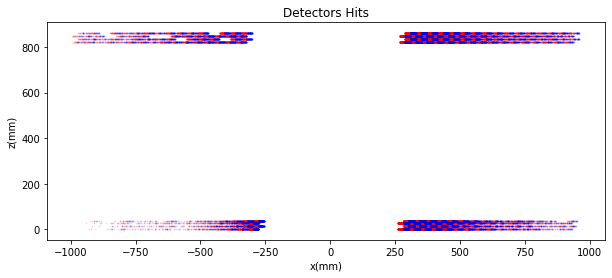

In [212]:
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(left,z,c="r",marker="o", s = 1, alpha=0.1)
ax.scatter(right,z,c="b",marker="o",s = 1,alpha=0.1)
ax.set_xlabel("x(mm)")
ax.set_ylabel("z(mm)")
plt.title("Detectors Hits")

In [208]:
#Getting only left chambers hits (chamber 0 & 1)
left = [i.xleft_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]
right = [i.xright_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]
z = [i.z_global for i in list(itertools.chain.from_iterable([j.hits for j in run260.Events if j.hits != []])) if i.chamber < 2]

Text(0.5, 1.0, 'Left detectors hits')

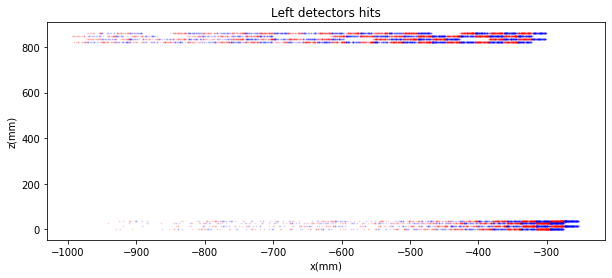

In [209]:
fig, ax = plt.subplots(figsize = (10,4))
ax.scatter(left,z,c="r",marker="o", s = 1, alpha=0.1)
ax.scatter(right,z,c="b",marker="o",s = 1,alpha=0.1)
ax.set_xlabel("x(mm)")
ax.set_ylabel("z(mm)")
plt.title("Left detectors hits")

In [213]:
#Getting only "Good" Events, at least 3 hits in 3 different layers into one chamber
#To be modified with smarter ways, using pandas
Good_events = []
Good_hits = []
for event in run260.Events:
    if event.Nhits > 2:
        for det in range(4):
            layers = []
            for hit in event.hits:
                if hit.chamber == det:
                    if hit.layer not in set(layers):
                        layers.append(hit.layer)         
            if len(layers) > 2:
                Good_events.append(event)
                


In [214]:
Good_events[1].describe()
[i.describe() for i in Good_events[1].hits]

Event number: 1
Number of hits recorded: 6
Hit number: 0
Chamber: 0
Layer: 4
Hit number: 1
Chamber: 0
Layer: 1
Hit number: 2
Chamber: 0
Layer: 2
Hit number: 3
Chamber: 3
Layer: 3
Hit number: 4
Chamber: 3
Layer: 4
Hit number: 5
Chamber: 3
Layer: 1


[None, None, None, None, None, None]

In [215]:
#Local fit in each chamber
fits = []
for detector in range(4):
    cfit = []
    for event in Good_events:
        left = [i.xleft_global for i in event.hits if i.chamber == detector]
        right = [i.xright_global for i in event.hits if i.chamber == detector]      
        z = [i.z_global for i in event.hits if i.chamber == detector]
        
        x = [(i+j)/2.0 for i,j in zip(left,right)]
        print(x,z)
        if len(x) > 2:
            cfit.append(np.polyfit(x,z,deg = 1))
    fits.append(cfit)    

[-826.2, -889.2, -868.2] [862.5, 823.5, 836.5]
[-826.2, -889.2, -868.2] [862.5, 823.5, 836.5]
[] []
[] []
[-343.20000000000005] [823.5]
[-343.20000000000005] [823.5]
[] []
[] []
[-469.20000000000005, -910.2, -910.2, -469.20000000000005, -952.2] [849.5, 836.5, 862.5, 849.5, 862.5]
[-469.20000000000005, -910.2, -910.2, -469.20000000000005, -952.2] [849.5, 836.5, 862.5, 849.5, 862.5]
[-469.20000000000005, -910.2, -910.2, -469.20000000000005, -952.2] [849.5, 836.5, 862.5, 849.5, 862.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-385.20000000000005, -532.2, -385.20000000000005, -511.20000000000005, -364.20000000000005, -364.20000000000005] [823.5, 836.5, 849.5, 823.5, 862.5, 836.5]
[-385.20000000000005, -532.2, -385.20000000000005, -511.20000000000005, -364.20000000000005, -364.20000000000005] [823.5, 836.5, 849.5, 823.5, 862.5, 836.5]
[] []
[] []
[] []
[] []
[-385.20000000000005, -385.20000000000005, -637.2, -616.2, -658.2] [823.5, 849.5, 823.5, 862.5, 836.5]
[-385.

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-322.20000000000005, -322.20000000000005, -343.20000000000005] [836.5, 862.5, 823.5]
[] []
[] []
[] []
[] []
[-469.20000000000005, -490.20000000000005, -490.20000000000005] [849.5, 836.5, 862.5]
[] []
[] []
[] []
[] []
[-700.2, -721.2, -406.20000000000005, -343.20000000000005, -700.2, -364.20000000000005, -364.20000000000005] [836.5, 823.5, 862.5, 849.5, 862.5, 836.5, 836.5]
[-700.2, -721.2, -406.20000000000005, -343.20000000000005, -700.2, -364.20000000000005, -364.20000000000005] [836.5, 823.5, 862.5, 849.5, 862.5, 836.5, 836.5]
[-700.2, -721.2, -406.20000000000005, -343.20000000000005, -700.2, -364.20000000000005, -364.20000000000005] [836.5, 823.5, 862.5, 849.5, 862.5, 836.5, 836.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-511.20000000000005, -511.20000000000005, -490.20000000000005, -490.20000000000005] [823.5, 849.5, 862.5, 836.5]
[-511.20000000000005, -511.20000000000005, -490.20000000000005, -490.200000000000

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)



[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-385.20000000000005, -427.20000000000005, -364.20000000000005] [849.5, 823.5, 862.5]
[-385.20000000000005, -427.20000000000005, -364.20000000000005] [849.5, 823.5, 862.5]
[-385.20000000000005, -427.20000000000005, -364.20000000000005] [849.5, 823.5, 862.5]
[-343.20000000000005, -553.2, -553.2, -532.2, -322.20000000000005] [823.5, 849.5, 823.5, 862.5, 836.5]
[] []
[] []
[-763.2, -742.2, -763.2, -784.2] [849.5, 862.5, 823.5, 836.5]
[-385.20000000000005, -427.20000000000005, -322.20000000000005, -469.20000000000005, -448.20000000000005, -427.20000000000005] [849.5, 849.5, 836.5, 823.5, 836.5, 823.5]
[-385.20000000000005, -427.20000000000005, -322.20000000000005, -469.20000000000005, -448.20000000000005, -427.20000000000005] [849.5, 849.5, 836.5, 823.5, 836.5, 823.5]
[] []
[] []
[] []
[] []
[] []
[] []
[-763.2, -742.2, -721.2, -742.2, -700.2] [823.5, 836.5, 849.5, 862.5, 862.5]
[-763.2, -742.2, -721.2, -742.2, -700.2] [823.5, 836.5, 8

[] []
[] []
[] []
[-910.2, -322.20000000000005, -931.2, -931.2, -322.20000000000005, -343.20000000000005, -952.2] [862.5, 836.5, 849.5, 823.5, 862.5, 823.5, 836.5]
[-910.2, -322.20000000000005, -931.2, -931.2, -322.20000000000005, -343.20000000000005, -952.2] [862.5, 836.5, 849.5, 823.5, 862.5, 823.5, 836.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-427.20000000000005, -406.20000000000005, -385.20000000000005] [823.5, 862.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[-364.20000000000005, -427.20000000000005, -406.20000000000005, -427.20000000000005] [862.5, 823.5, 862.5, 849.5]
[-364.20000000000005, -427.20000000000005, -406.20000000000005, -427.20000000000005] [862.5, 823.5, 862.5, 849.5]
[-364.20000000000005, -427.20000000000005, -406.20000000000005, -427.20000000000005] [862.5, 823.5, 862.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[] []
[-385.20000000000005, -364.20000000000005, -385.20000000000005, -364.20000000000005] [823.5, 862.5, 849.5, 836.5]
[] []
[] []
[] []
[] [

[] []
[] []
[-889.2, -889.2, -868.2] [823.5, 849.5, 836.5]
[-889.2, -889.2, -868.2] [823.5, 849.5, 836.5]
[-889.2, -889.2, -868.2] [823.5, 849.5, 836.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-469.20000000000005, -490.20000000000005, -490.20000000000005, -469.20000000000005] [823.5, 836.5, 862.5, 849.5]
[-469.20000000000005, -490.20000000000005, -490.20000000000005, -469.20000000000005] [823.5, 836.5, 862.5, 849.5]
[-469.20000000000005, -490.20000000000005, -490.20000000000005, -469.20000000000005] [823.5, 836.5, 862.5, 849.5]
[] []
[] []
[-385.20000000000005, -385.20000000000005, -595.2, -364.20000000000005, -553.2] [823.5, 849.5, 823.5, 836.5, 849.5]
[-385.20000000000005, -385.20000000000005, -595.2, -364.20000000000005, -553.2] [823.5, 849.5, 823.5, 836.5, 849.5]
[-385.20000000000005, -385.20000000000005, -595.2, -364.20000000000005, -553.2] [823.5, 849.5, 823.5, 836.5, 849.5]
[-385.20000000000005, -385.20000000000005, -595.2, -364.20000000000005, -553.2] [823.5, 849.5, 823.5, 8

[-637.2, -553.2, -532.2, -616.2, -595.2, -616.2, -532.2, -553.2] [823.5, 823.5, 862.5, 836.5, 849.5, 862.5, 836.5, 849.5]
[-385.20000000000005, -364.20000000000005, -385.20000000000005, -364.20000000000005] [823.5, 862.5, 849.5, 836.5]
[] []
[] []
[] []
[-826.2, -847.2] [862.5, 823.5]
[] []
[] []
[-742.2, -763.2, -742.2, -721.2] [836.5, 823.5, 862.5, 849.5]
[-742.2, -763.2, -742.2, -721.2] [836.5, 823.5, 862.5, 849.5]
[-742.2, -763.2, -742.2, -721.2] [836.5, 823.5, 862.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-469.20000000000005, -553.2, -490.20000000000005, -532.2, -511.20000000000005] [849.5, 823.5, 836.5, 836.5, 823.5]
[-469.20000000000005, -553.2, -490.20000000000005, -532.2, -511.20000000000005] [849.5, 823.5, 836.5, 836.5, 823.5]
[] []
[] []
[] []
[] []
[-721.2, -700.2, -721.2, -700.2] [823.5, 862.5, 849.5, 836.5]
[] []
[] []
[] []
[] []
[-616.2, -658.2, -637.2] [862.5, 836.5, 823.5]
[-616.2, -658.2, -637.2] [862.5, 836.5, 823.5]
[-616.2, -658.2, -63

[] []
[-427.20000000000005, -406.20000000000005, -385.20000000000005, -427.20000000000005, -385.20000000000005] [823.5, 862.5, 849.5, 849.5, 823.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-784.2, -763.2, -784.2, -763.2] [836.5, 849.5, 836.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[-616.2] [862.5]
[-616.2] [862.5]
[] []
[] []
[-637.2, -616.2, -658.2] [823.5, 862.5, 836.5]
[-637.2, -616.2, -658.2] [823.5, 862.5, 836.5]
[-805.2, -406.20000000000005, -763.2, -469.20000000000005, -742.2, -385.20000000000005, -805.2, -343.20000000000005, -742.2, -448.20000000000005, -826.2, -364.20000000000005, -784.2, -343.20000000000005, -763.2, -469.20000000000005, -784.2, -385.20000000000005, -364.20000000000005, -364.20000000000005] [823.5, 862.5, 849.5, 823.5, 862.5, 849.5, 849.5, 849.5, 862.5, 836.5, 862.5, 862.5, 836.5, 823.5, 823.5, 849.5, 836.5, 823.5, 836.5, 862.5]
[-805.2, -406.20000000000005, -763.2, -469.20000000000005, -742.2, -385.20000000000005, -805.2, -343.20000000000005

[] []
[] []
[] []
[] []
[] []
[] []
[-595.2, -490.20000000000005, -616.2, -406.20000000000005, -637.2, -322.20000000000005, -595.2, -616.2, -532.2, -616.2, -364.20000000000005, -574.2, -490.20000000000005, -595.2, -595.2, -574.2] [823.5, 862.5, 836.5, 862.5, 823.5, 862.5, 849.5, 836.5, 862.5, 862.5, 862.5, 862.5, 862.5, 849.5, 823.5, 862.5]
[-595.2, -490.20000000000005, -616.2, -406.20000000000005, -637.2, -322.20000000000005, -595.2, -616.2, -532.2, -616.2, -364.20000000000005, -574.2, -490.20000000000005, -595.2, -595.2, -574.2] [823.5, 862.5, 836.5, 862.5, 823.5, 862.5, 849.5, 836.5, 862.5, 862.5, 862.5, 862.5, 862.5, 849.5, 823.5, 862.5]
[-595.2, -490.20000000000005, -616.2, -406.20000000000005, -637.2, -322.20000000000005, -595.2, -616.2, -532.2, -616.2, -364.20000000000005, -574.2, -490.20000000000005, -595.2, -595.2, -574.2] [823.5, 862.5, 836.5, 862.5, 823.5, 862.5, 849.5, 836.5, 862.5, 862.5, 862.5, 862.5, 862.5, 849.5, 823.5, 862.5]
[] []
[-511.20000000000005, -322.2000000000

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-427.20000000000005, -427.20000000000005] [823.5, 849.5]
[-427.20000000000005, -427.20000000000005] [823.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-910.2, -931.2, -952.2, -931.2] [862.5, 849.5, 836.5, 823.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-364.20000000000005, -343.20000000000005, -343.20000000000005, -322.20000000000005, -322.20000000000005] [836.5, 849.5, 823.5, 836.5, 862.5]
[-469.20000000000005, -595.2, -469.20000000000005, -448.20000000000005] [823.5, 823.5, 849.5, 836.5]
[-469.20000000000005, -595.2, -469.20000000000005, -448.20000000000005] [823.5, 823.5, 849.5, 836.5]
[-469.20000000000005, -595.2, -469.20000000000005, -448.20000000000005] [823.5, 823.5, 849.5, 836.5]
[-469.20000000000005, -595.2, -469.20000000000005, -4

[-343.20000000000005, -343.20000000000005, -322.20000000000005, -322.20000000000005] [849.5, 823.5, 836.5, 862.5]
[] []
[] []
[] []
[] []
[] []
[] []
[-511.20000000000005, -532.2, -511.20000000000005] [849.5, 836.5, 823.5]
[-511.20000000000005, -532.2, -511.20000000000005] [849.5, 836.5, 823.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-574.2, -595.2] [862.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[-553.2, -595.2, -427.20000000000005, -574.2] [849.5, 823.5, 849.5, 862.5]
[] []
[] []
[] []
[] []
[-826.2, -805.2] [836.5, 849.5]
[-742.2, -721.2, -700.2] [836.5, 849.5, 862.5]
[-742.2, -721.2, -700.2] [836.5, 849.5, 862.5]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-406.20000000000005, -427.20000000000005, -385.20000000000005] [862.5, 823.5, 849.5]
[-406.20000000000005, -427.20000000000005, -385.20000000000005] [862.5, 823.5, 849.5]
[-364.20000000000005, -364.20000000000005, -385.20000000000005, -385.20000000000005] [862

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-763.2] [849.5]
[-763.2] [849.5]
[] []
[] []
[] []
[] []
[] []
[] []
[-343.20000000000005, -322.20000000000005, -343.20000000000005] [823.5, 862.5, 849.5]
[] []
[] []
[] []
[] []
[-448.20000000000005, -427.20000000000005, -469.20000000000005] [836.5, 849.5, 823.5]
[-448.20000000000005, -427.20000000000005, -469.20000000000005] [836.5, 849.5, 823.5]
[] []
[] []
[] []
[] []
[-910.2, -910.2, -889.175, -931.2] [836.5, 862.5, 849.5, 823.5]
[] []
[] []
[] []
[-385.20000000000005, -385.20000000000005, -364.20000000000005] [823.5, 849.5, 862.5]
[-385.20000000000005, -385.20000000000005, -364.20000000000005] [823.5, 849.5, 862.5]
[] []
[] []
[] []
[] []
[-385.20000000000005, -385.20000000000005, -364.20000000000005, -364.20000000000005] [823.5, 849.5, 862.5, 836.5]
[] []
[] []
[] []
[] []
[] []
[] []
[-658.2] [836.5]
[-658.2] [836.5]
[] []
[] []
[] []
[] []
[-427.200000000000

[] []
[] []
[] []
[] []
[-317.4, -296.4, -317.4] [13.0, 26.0, 39.0]
[-359.4, -359.4, -338.4, -359.4, -338.4, -380.4, -380.4] [13.0, 39.0, 0.0, 39.0, 26.0, 0.0, 26.0]
[-359.4, -359.4, -338.4, -359.4, -338.4, -380.4, -380.4] [13.0, 39.0, 0.0, 39.0, 26.0, 0.0, 26.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-338.4, -359.4, -359.4] [26.0, 13.0, 39.0]
[-317.4, -317.4, -338.4, -296.4] [13.0, 39.0, 0.0, 26.0]
[-317.4, -317.4, -338.4, -296.4] [13.0, 39.0, 0.0, 26.0]
[-317.4, -317.4, -338.4, -296.4] [13.0, 39.0, 0.0, 26.0]
[-800.4, -800.4, -779.4] [0.0, 26.0, 39.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4, -275.4, -296.4, -275.4] [0.0, 39.0, 26.0, 13.0]
[-296.4, -275.4, -296.4, -275.4] [0.0, 39.0, 26.0, 13.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-380.4, -359.4, -338.4, -359.4, -317.4] [0.0, 13.0, 26.0, 39.0, 39.0]
[-380.4, -359.4, -338.4, -359.4, -317.4] [0.0, 13.0, 26.0, 39.0, 39.0]
[] []


[] []
[] []
[] []
[] []
[] []
[-380.4, -380.4, -359.4] [0.0, 26.0, 39.0]
[] []
[] []
[-758.4, -737.4, -758.4] [0.0, 39.0, 26.0]
[-758.4, -737.4, -758.4] [0.0, 39.0, 26.0]
[] []
[] []
[] []
[] []
[] []
[-296.4, -296.4, -317.4, -275.4] [0.0, 26.0, 13.0, 39.0]
[-296.4, -296.4, -317.4, -275.4] [0.0, 26.0, 13.0, 39.0]
[-296.4, -296.4, -317.4, -275.4] [0.0, 26.0, 13.0, 39.0]
[-296.4, -296.4, -317.4, -275.4] [0.0, 26.0, 13.0, 39.0]
[-317.4, -296.4, -317.4, -296.4] [13.0, 26.0, 39.0, 0.0]
[-317.4, -296.4, -317.4, -296.4] [13.0, 26.0, 39.0, 0.0]
[-317.4, -296.4, -317.4, -296.4] [13.0, 26.0, 39.0, 0.0]
[] []
[] []
[-275.4] [39.0]
[-275.4] [39.0]
[-275.4] [13.0]
[-359.4, -380.4, -380.4, -359.4] [39.0, 0.0, 26.0, 13.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-548.4, -527.4, -548.4, -527.4, -506.4] [0.0, 13.0, 26.0, 39.0, 26.0]
[-548.4, -527.4, -548.4, -527.4, -506.4] [0.0, 13.0, 26.

[-338.4, -317.4, -317.4, -338.4] [0.0, 39.0, 13.0, 26.0]
[-338.4, -317.4, -317.4, -338.4] [0.0, 39.0, 13.0, 26.0]
[] []
[] []
[] []
[] []
[] []
[-359.4, -338.4, -380.4, -338.4, -359.4, -338.4] [13.0, 26.0, 0.0, 0.0, 39.0, 26.0]
[-359.4, -338.4, -380.4, -338.4, -359.4, -338.4] [13.0, 26.0, 0.0, 0.0, 39.0, 26.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-317.4, -317.4, -296.4, -338.4] [13.0, 39.0, 26.0, 0.0]
[-317.4, -317.4, -296.4, -338.4] [13.0, 39.0, 26.0, 0.0]
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4, -695.4, -275.4, -296.4, -275.4] [0.0, 39.0, 39.0, 26.0, 13.0]
[-296.4, -695.4, -275.4, -296.4, -275.4] [0.0, 39.0, 39.0, 26.0, 13.0]
[-296.4, -695.4, -275.4, -296.4, -275.4] [0.0, 39.0, 39.0, 26.0, 13.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4, -317.4, -296.4, -275.4] [26.0, 13.0, 0.0, 39.0]
[-296.4, -317.4, -296.4, -275.4] [26.0, 13.0, 0.0, 39.0]
[-296.4, -317.4, -296.4, -275.4] [26.0, 13.0, 0.0, 39.0

[] []
[] []
[] []
[] []
[] []
[-296.4, -275.4, -275.4, -296.4] [0.0, 39.0, 13.0, 26.0]
[-296.4, -275.4, -275.4, -296.4] [0.0, 39.0, 13.0, 26.0]
[-296.4, -275.4, -275.4, -296.4] [0.0, 39.0, 13.0, 26.0]
[-296.4, -275.4, -275.4, -296.4] [0.0, 39.0, 13.0, 26.0]
[] []
[] []
[-317.4, -296.4, -296.4, -338.4, -317.4] [13.0, 26.0, 26.0, 0.0, 39.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-338.4, -317.4, -359.4, -338.4] [26.0, 39.0, 13.0, 0.0]
[] []
[] []
[] []
[-464.4] [26.0]
[-464.4] [26.0]
[] []
[] []
[] []
[] []
[] []
[] []
[-275.4] [13.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4, -275.4, -296.4] [26.0, 39.0, 0.0]
[-296.4, -275.4, -296.4] [26.0, 39.0, 0.0]
[-296.4, -275.4, -296.4] [26.0, 39.0, 0.0]
[] []
[] []
[-296.4, -296.4, -317.4, -317.4] [26.0, 0.0, 13.0, 39.0]
[-296.4, -296.4, -317.4, -

[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-422.4, -443.4, -422.4, -443.4] [26.0, 13.0, 0.0, 39.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-338.4] [0.0]
[-338.4] [0.0]
[] []
[] []
[-380.4, -359.4, -380.4, -401.4] [26.0, 39.0, 0.0, 13.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4] [0.0]
[-359.4, -296.4, -275.4, -317.4, -275.4] [13.0, 0.0, 13.0, 13.0, 39.0]
[-359.4, -296.4, -275.4, -317.4, -275.4] [13.0, 0.0, 13.0, 13.0, 39.0]
[-359.4, -296.4, -275.4, -317.4, -275.4] [13.0, 0.0, 13.0, 13.0, 39.0]
[-359.4, -296.4, -275.4, -317.4, -275.4] [13.0, 0.0, 13.0, 13.0, 39.0]
[] []
[] []
[-296.4, -296.4, -275.4, -317.4] [26.0, 0.0, 39.0, 13.0]
[-296.4, -296.4, -275.4, -317.4] [26.0, 0.0, 39.0, 13.0]
[] []
[] []
[] []
[-443.4] [39.0]
[-443.4] [39.0]
[-296.4, -338.4, -275.4, -3

[] []
[-884.4] [0.0]
[-884.4] [0.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[-275.4] [13.0]
[] []
[] []
[] []
[] []
[-443.4, -422.4, -464.4, -401.4] [13.0, 26.0, 0.0, 39.0]
[-443.4, -422.4, -464.4, -401.4] [13.0, 26.0, 0.0, 39.0]
[] []
[] []
[] []
[] []
[] []
[-380.4, -338.4, -275.4, -716.4, -359.4, -317.4, -380.4, -296.4] [0.0, 26.0, 39.0, 26.0, 13.0, 39.0, 0.0, 26.0]
[] []
[] []
[-275.4, -296.4, -275.4, -296.4] [39.0, 0.0, 13.0, 26.0]
[-275.4, -296.4, -275.4, -296.4] [39.0, 0.0, 13.0, 26.0]
[] []
[] []
[] []
[] []
[] []
[-275.4, -296.4, -275.4] [13.0, 0.0, 39.0]
[] []
[] []
[] []
[] []
[-359.4, -338.4, -380.4, -317.4, -338.4] [13.0, 26.0, 0.0, 39.0, 0.0]
[] []
[] []
[] []
[] []
[] []
[] []
[-296.4, -275.4, -275.4, -296.4] [0.0, 39.0, 13.0, 26.0]
[-422.4] [0.0]
[] []
[] []
[] []
[] []
[] []
[] []
[] 

[561.4, 561.4, 582.4, 582.4] [836.5, 862.5, 823.5, 849.5]
[645.4, 645.4, 666.4, 666.4] [836.5, 862.5, 823.5, 849.5]
[645.4, 645.4, 666.4, 666.4] [836.5, 862.5, 823.5, 849.5]
[834.4, 813.4, 855.4, 834.4] [849.5, 862.5, 836.5, 823.5]
[834.4, 813.4, 855.4, 834.4] [849.5, 862.5, 836.5, 823.5]
[] []
[] []
[435.4, 435.4, 456.4, 414.4] [836.5, 862.5, 823.5, 849.5]
[435.4, 435.4, 456.4, 414.4] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 372.39, 372.4] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 372.39, 372.4] [836.5, 862.5, 823.5, 849.5]
[519.4, 519.4, 540.4, 540.4] [862.5, 836.5, 823.5, 849.5]
[519.4, 519.4, 540.4, 540.4] [862.5, 836.5, 823.5, 849.5]
[519.4, 519.4, 540.4, 540.4] [862.5, 836.5, 823.5, 849.5]
[309.4, 309.4, 288.4, 309.4, 330.4, 288.39799999999997, 309.4] [836.5, 862.5, 823.5, 862.5, 823.5, 849.5, 836.5]
[309.4, 309.4, 288.4, 309.4, 330.4, 288.39799999999997, 309.4] [836.5, 862.5, 823.5, 862.5, 823.5, 849.5, 836.5]
[309.4, 309.4, 288.4, 309.4, 330.4, 288.39799999999997, 309.4] [

[813.4, 813.4, 792.4, 792.4] [836.5, 862.5, 823.5, 849.5]
[] []
[] []
[351.4, 351.4, 372.385, 372.405] [836.5, 862.5, 849.5, 823.5]
[351.4, 351.4, 372.385, 372.405] [836.5, 862.5, 849.5, 823.5]
[] []
[624.4, 603.4, 603.4, 624.4] [823.5, 836.5, 862.5, 849.5]
[624.4, 603.4, 603.4, 624.4] [823.5, 836.5, 862.5, 849.5]
[] []
[] []
[309.4, 435.4, 519.4, 309.4, 435.4, 456.4, 330.4, 456.4, 330.4] [836.5, 836.5, 862.5, 862.5, 862.5, 823.5, 823.5, 849.5, 849.5]
[309.4, 435.4, 519.4, 309.4, 435.4, 456.4, 330.4, 456.4, 330.4] [836.5, 836.5, 862.5, 862.5, 862.5, 823.5, 823.5, 849.5, 849.5]
[] []
[435.4, 435.4] [836.5, 862.5]
[351.4, 372.395, 372.38, 351.4] [862.5, 823.5, 849.5, 836.5]
[351.4, 372.395, 372.38, 351.4] [862.5, 823.5, 849.5, 836.5]
[351.4, 918.4, 309.4, 351.4, 897.4, 309.4, 330.4, 897.4, 330.4, 876.4, 918.4] [836.5, 823.5, 836.5, 862.5, 836.5, 862.5, 849.5, 862.5, 849.5, 849.5, 849.5]
[351.4, 918.4, 309.4, 351.4, 897.4, 309.4, 330.4, 897.4, 330.4, 876.4, 918.4] [836.5, 823.5, 836.5, 86

[624.4, 624.4, 939.4, 309.4, 645.4, 792.4, 603.4] [849.5, 823.5, 862.5, 862.5, 836.5, 823.5, 862.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[351.4, 330.4, 351.4] [836.5, 849.5, 862.5]
[351.4, 330.4, 351.4] [836.5, 849.5, 862.5]
[372.4, 372.4, 687.4, 351.4, 708.4, 351.41999999999996, 687.4, 708.4] [823.5, 849.5, 862.5, 836.5, 823.5, 862.5, 836.5, 849.5]
[372.4, 372.4, 687.4, 351.4, 708.4, 351.41999999999996, 687.4, 708.4] [823.5, 849.5, 862.5, 836.5, 823.5, 862.5, 836.5, 849.5]
[330.4, 330.4, 309.4, 309.4] [849.5, 823.5, 836.5, 862.5]
[330.4, 330.4, 309.4, 309.4] [849.5, 823.5, 836.5, 862.5]
[372.41499999999996, 393.4, 393.4] [849.5, 836.5, 862.5]
[372.41499999999996, 393.4, 393.4] [849.5, 836.5, 862.5]
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 330.4] [836.5, 862.5, 849.5]
[351.4, 351.4, 330.4] [836.5, 862.5, 849.5]
[603.4, 309.4, 897.4, 372.4, 939.4, 435.4, 540.4, 771.4, 309.4, 81

[372.4, 372.4, 351.41499999999996] [823.5, 849.5, 862.5]
[] []
[] []
[897.4, 876.4, 918.4, 897.4] [836.5, 849.5, 823.5, 862.5]
[897.4, 876.4, 918.4, 897.4] [836.5, 849.5, 823.5, 862.5]
[435.4, 414.4, 393.4, 414.4, 393.4] [836.5, 823.5, 836.5, 849.5, 862.5]
[435.4, 414.4, 393.4, 414.4, 393.4] [836.5, 823.5, 836.5, 849.5, 862.5]
[435.4, 414.4, 393.4, 414.4, 393.4] [836.5, 823.5, 836.5, 849.5, 862.5]
[] []
[] []
[] []
[498.4, 498.4, 519.4, 477.4] [849.5, 823.5, 836.5, 862.5]
[498.4, 498.4, 519.4, 477.4] [849.5, 823.5, 836.5, 862.5]
[309.4, 309.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 862.5, 836.5]
[897.4, 897.4, 918.4] [836.5, 862.5, 823.5]
[897.4, 897.4, 918.4] [836.5, 862.5, 823.5]
[] []
[] []
[288.4, 288.4, 309.4, 309.4] [823.5, 849.5, 862.5, 836.5]
[582.4, 561.4, 540.4] [849.5, 836.5, 823.5]
[] []
[309.4, 309.4, 288.3995, 288.398] [836.5, 862.5, 849.5, 823.5]
[] []
[] []
[] []
[372.4, 372.4, 372.39, 393.4, 393.4] [849.5, 823.5, 849.5, 8

[372.395, 393.4, 393.4, 372.4] [849.5, 836.5, 862.5, 823.5]
[372.395, 393.4, 393.4, 372.4] [849.5, 836.5, 862.5, 823.5]
[792.4, 771.3999999999999, 813.4] [849.5, 862.5, 836.5]
[792.4, 771.3999999999999, 813.4] [849.5, 862.5, 836.5]
[] []
[] []
[351.4, 351.4, 372.40999999999997, 372.405] [836.5, 862.5, 849.5, 823.5]
[351.4, 351.4, 372.40999999999997, 372.405] [836.5, 862.5, 849.5, 823.5]
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 849.5, 823.5]
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 849.5, 823.5]
[309.4, 309.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[351.4, 351.4, 330.4, 372.4, 330.4, 372.4] [836.5, 862.5, 823.5, 823.5, 849.5, 849.5]
[351.4, 351.4, 330.4, 372.4, 330.4, 372.4] [836.5, 862.5, 823.5, 823.5, 849.5, 849.5]
[414.4, 393.4, 414.4, 393.4] [823.5, 836.5, 849.5, 862.5]
[414.4, 393.4, 414.4, 393.4] [82

[288.4] [823.5]
[750.4, 750.4, 771.4, 771.4000000000001] [849.5, 823.5, 836.5, 862.5]
[330.4, 393.4, 414.4, 309.4, 393.4, 309.4, 330.4] [849.5, 836.5, 823.5, 836.5, 862.5, 862.5, 823.5]
[330.4, 393.4, 414.4, 309.4, 393.4, 309.4, 330.4] [849.5, 836.5, 823.5, 836.5, 862.5, 862.5, 823.5]
[] []
[351.4, 351.4, 372.4, 372.41499999999996] [836.5, 862.5, 823.5, 823.5]
[351.4, 351.4, 372.4, 372.41499999999996] [836.5, 862.5, 823.5, 823.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[456.4, 750.4, 477.4, 582.4, 624.4, 729.4, 288.4, 414.4, 498.4, 666.4, 582.4, 624.4, 288.4, 393.4, 435.4, 498.4, 645.4, 435.4, 477.4, 603.4, 414.4, 603.4] [823.5, 849.5, 862.5, 849.5, 823.5, 862.5, 823.5, 823.5, 823.5, 823.5, 823.5, 849.5, 849.5, 862.5, 836.5, 849.5, 836.5, 862.5, 836.5, 862.5, 849.5, 836.5]
[456.4, 750.4, 477.4, 582.4, 624.4, 729.4, 288.4, 414.4, 498.4, 666.4, 582.4, 624.4, 288.4, 393.4, 435.4, 498.4, 645.4, 435.4, 477.4, 603.4,

[498.4, 519.4, 519.4] [849.5, 862.5, 836.5]
[498.4, 519.4, 519.4] [849.5, 862.5, 836.5]
[351.4, 351.4, 372.405, 372.375] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 372.405, 372.375] [836.5, 862.5, 823.5, 849.5]
[] []
[393.4, 414.4, 393.4, 414.4] [862.5, 823.5, 836.5, 849.5]
[393.4, 414.4, 393.4, 414.4] [862.5, 823.5, 836.5, 849.5]
[] []
[] []
[456.4, 708.4, 330.4, 456.4, 687.4, 435.4, 309.4, 435.4, 708.4, 687.4] [823.5, 823.5, 849.5, 849.5, 862.5, 836.5, 862.5, 862.5, 849.5, 836.5]
[456.4, 708.4, 330.4, 456.4, 687.4, 435.4, 309.4, 435.4, 708.4, 687.4] [823.5, 823.5, 849.5, 849.5, 862.5, 836.5, 862.5, 862.5, 849.5, 836.5]
[393.4, 393.4, 372.395, 372.38] [836.5, 862.5, 823.5, 849.5]
[393.4, 393.4, 372.395, 372.38] [836.5, 862.5, 823.5, 849.5]
[372.4, 435.4, 498.4, 582.4, 372.4, 456.4, 519.4, 393.4, 414.4, 498.4, 393.4, 351.41999999999996] [823.5, 836.5, 849.5, 823.5, 849.5, 823.5, 836.5, 836.5, 849.5, 823.5, 862.5, 836.5]
[372.4, 435.4, 498.4, 582.4, 372.4, 456.4, 519.4, 393.4, 414.4, 4

[435.4, 498.4, 288.4, 435.4, 498.4, 540.4, 288.4, 456.4, 477.4, 540.4, 309.4, 456.4, 477.4, 561.4, 288.399, 414.4, 561.4, 414.4] [836.5, 823.5, 823.5, 862.5, 849.5, 849.5, 849.5, 849.5, 836.5, 823.5, 862.5, 823.5, 862.5, 836.5, 849.5, 823.5, 862.5, 849.5]
[435.4, 498.4, 288.4, 435.4, 498.4, 540.4, 288.4, 456.4, 477.4, 540.4, 309.4, 456.4, 477.4, 561.4, 288.399, 414.4, 561.4, 414.4] [836.5, 823.5, 823.5, 862.5, 849.5, 849.5, 849.5, 849.5, 836.5, 823.5, 862.5, 823.5, 862.5, 836.5, 849.5, 823.5, 862.5, 849.5]
[519.4, 372.41499999999996, 414.4, 393.4, 414.4, 351.4, 372.41999999999996, 393.4, 393.4, 351.4] [862.5, 849.5, 823.5, 862.5, 849.5, 862.5, 823.5, 836.5, 862.5, 836.5]
[519.4, 372.41499999999996, 414.4, 393.4, 414.4, 351.4, 372.41999999999996, 393.4, 393.4, 351.4] [862.5, 849.5, 823.5, 862.5, 849.5, 862.5, 823.5, 836.5, 862.5, 836.5]
[] []
[603.4, 288.4, 729.4, 414.4, 477.4, 624.4, 771.4, 288.4, 351.4, 414.4, 477.4, 645.4, 309.4, 351.4, 435.4, 498.4, 645.4, 309.4, 393.4, 456.4, 498.4

[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[] []
[] []
[] []
[897.4] [862.5]
[288.4, 288.4, 309.4, 309.4, 330.4, 330.4] [823.5, 849.5, 836.5, 862.5, 823.5, 849.5]
[288.4, 288.4, 309.4, 309.4, 330.4, 330.4] [823.5, 849.5, 836.5, 862.5, 823.5, 849.5]
[] []
[] []
[] []
[] []
[309.4, 309.4, 330.4, 330.4] [862.5, 836.5, 823.5, 849.5]
[561.4, 750.4, 561.4, 582.4, 750.4, 582.4] [862.5, 823.5, 836.5, 823.5, 823.5, 849.5]
[561.4, 750.4, 561.4, 582.4, 750.4, 582.4] [862.5, 823.5, 836.5, 823.5, 823.5, 849.5]
[372.38, 372.40999999999997, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[372.38, 372.40999999999997, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[519.4, 519.4, 498.4] [836.5, 862.5, 849.5]
[519.4, 519.4, 498.4] [836.5, 862.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[] []
[435.4, 435.4, 456.4, 456.4] [862.5, 836.5, 823.5, 849.5]
[435.4, 435.4, 456.4, 456.4] [862.5, 836.5, 823.5, 849.5]
[288.4, 288.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[351.4] [862.5]
[351.4, 351.4, 372.40999

[330.4, 708.4, 351.41999999999996, 729.4] [849.5, 849.5, 862.5, 836.5]
[330.4, 708.4, 351.41999999999996, 729.4] [849.5, 849.5, 862.5, 836.5]
[939.4, 939.4] [862.5, 836.5]
[330.4, 330.4, 351.4, 351.4] [849.5, 823.5, 836.5, 862.5]
[330.4, 330.4, 351.4, 351.4] [849.5, 823.5, 836.5, 862.5]
[] []
[] []
[351.4, 351.4] [862.5, 836.5]
[477.4, 477.4, 498.4, 498.4] [862.5, 836.5, 823.5, 849.5]
[477.4, 477.4, 498.4, 498.4] [862.5, 836.5, 823.5, 849.5]
[372.405, 855.4, 351.395, 834.4, 393.4, 855.4, 834.4] [823.5, 836.5, 862.5, 849.5, 836.5, 862.5, 823.5]
[372.405, 855.4, 351.395, 834.4, 393.4, 855.4, 834.4] [823.5, 836.5, 862.5, 849.5, 836.5, 862.5, 823.5]
[372.405, 855.4, 351.395, 834.4, 393.4, 855.4, 834.4] [823.5, 836.5, 862.5, 849.5, 836.5, 862.5, 823.5]
[372.405, 855.4, 351.395, 834.4, 393.4, 855.4, 834.4] [823.5, 836.5, 862.5, 849.5, 836.5, 862.5, 823.5]
[456.4, 456.4, 435.4, 477.4, 435.4] [849.5, 823.5, 836.5, 836.5, 862.5]
[456.4, 456.4, 435.4, 477.4, 435.4] [849.5, 823.5, 836.5, 836.5, 8

[477.4, 498.4, 645.4, 498.4] [862.5, 823.5, 862.5, 849.5]
[477.4, 498.4, 645.4, 498.4] [862.5, 823.5, 862.5, 849.5]
[414.4, 477.4, 309.4, 771.4, 351.4, 834.4, 414.4, 477.4, 288.4, 771.4, 435.4, 792.4, 498.4, 288.4, 792.4000000000001, 393.4, 498.4, 813.4, 330.4, 309.4, 330.4, 309.4] [849.5, 862.5, 862.5, 862.5, 836.5, 849.5, 823.5, 836.5, 823.5, 836.5, 836.5, 823.5, 823.5, 849.5, 849.5, 862.5, 849.5, 836.5, 849.5, 862.5, 849.5, 836.5]
[414.4, 477.4, 309.4, 771.4, 351.4, 834.4, 414.4, 477.4, 288.4, 771.4, 435.4, 792.4, 498.4, 288.4, 792.4000000000001, 393.4, 498.4, 813.4, 330.4, 309.4, 330.4, 309.4] [849.5, 862.5, 862.5, 862.5, 836.5, 849.5, 823.5, 836.5, 823.5, 836.5, 836.5, 823.5, 823.5, 849.5, 849.5, 862.5, 849.5, 836.5, 849.5, 862.5, 849.5, 836.5]
[414.4, 477.4, 309.4, 771.4, 351.4, 834.4, 414.4, 477.4, 288.4, 771.4, 435.4, 792.4, 498.4, 288.4, 792.4000000000001, 393.4, 498.4, 813.4, 330.4, 309.4, 330.4, 309.4] [849.5, 862.5, 862.5, 862.5, 836.5, 849.5, 823.5, 836.5, 823.5, 836.5, 83

[330.4, 330.4, 288.399, 288.3995, 309.4, 309.4] [823.5, 849.5, 823.5, 849.5, 836.5, 862.5]
[330.4, 330.4, 288.399, 288.3995, 309.4, 309.4] [823.5, 849.5, 823.5, 849.5, 836.5, 862.5]
[939.4, 939.4] [862.5, 836.5]
[330.4, 309.4, 309.4] [849.5, 862.5, 836.5]
[330.4, 309.4, 309.4] [849.5, 862.5, 836.5]
[288.4, 288.4, 351.4, 330.4, 351.4, 330.4, 288.39805, 309.4, 309.4] [823.5, 849.5, 836.5, 849.5, 862.5, 823.5, 823.5, 836.5, 862.5]
[288.4, 288.4, 351.4, 330.4, 351.4, 330.4, 288.39805, 309.4, 309.4] [823.5, 849.5, 836.5, 849.5, 862.5, 823.5, 823.5, 836.5, 862.5]
[309.4, 309.4, 288.40049999999997, 288.40099999999995] [862.5, 836.5, 823.5, 849.5]
[309.4, 309.4, 288.40049999999997, 288.40099999999995] [862.5, 836.5, 823.5, 849.5]
[372.39] [823.5]
[] []
[351.4, 351.4, 372.4, 372.39] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 372.4, 372.39] [836.5, 862.5, 823.5, 849.5]
[351.4, 372.4, 372.4, 393.4, 351.4, 372.405, 351.405] [862.5, 823.5, 849.5, 836.5, 836.5, 849.5, 836.5]
[351.4, 372.4, 372.4, 3

[477.4, 456.4, 477.4, 456.4] [836.5, 849.5, 862.5, 823.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[435.4, 519.4, 561.4, 645.4, 435.4, 519.4, 456.4, 498.4, 414.4, 498.4, 414.4, 456.4] [836.5, 836.5, 862.5, 836.5, 862.5, 862.5, 823.5, 823.5, 823.5, 849.5, 849.5, 849.5]
[435.4, 519.4, 561.4, 645.4, 435.4, 519.4, 456.4, 498.4, 414.4, 498.4, 414.4, 456.4] [836.5, 836.5, 862.5, 836.5, 862.5, 862.5, 823.5, 823.5, 823.5, 849.5, 849.5, 849.5]
[372.38, 372.395, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[372.38, 372.395, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[] []
[288.4, 309.4, 351.4, 330.4, 309.4, 330.4, 288.3995] [849.5, 836.5, 862.5, 849.5, 862.5, 823.5, 823.5]
[288.4, 309.4, 351.4, 330.4, 309.4, 330.4, 288.3995] [849.5, 836.5, 862.5, 849.5, 862.5, 823.5, 823.5]
[393.4, 414.4, 372.405, 372.4, 393.4] [836.5, 823.5, 823.5, 849.5, 862.5]
[393.4, 414.4, 372.405, 372.4, 393.4] [836.5, 823.5, 823.5, 849.5, 862.5]
[] [

[] []
[519.4, 519.4, 498.4, 498.4] [836.5, 862.5, 849.5, 823.5]
[519.4, 519.4, 498.4, 498.4] [836.5, 862.5, 849.5, 823.5]
[414.4, 435.4, 435.4] [823.5, 836.5, 862.5]
[414.4, 435.4, 435.4] [823.5, 836.5, 862.5]
[] []
[] []
[351.4, 330.4, 351.4, 330.4] [836.5, 849.5, 862.5, 823.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 849.5, 862.5, 823.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[330.4, 330.4, 309.4, 309.4] [823.5, 849.5, 836.5, 862.5]
[330.4, 351.4, 330.4, 351.4] [823.5, 836.5, 849.5, 862.5]
[330.4, 351.4, 330.4, 351.4] [823.5, 836.5, 849.5, 862.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[351.4, 330.4, 351.4, 330.4] [836.5, 823.5, 862.5, 849.5]
[351.4, 351.4, 372.40999999999997] [862.5, 836.5, 849.5]
[351.4, 351.4, 372.40999999999997] [862.5, 836.5, 849.5]
[372.41999999999996, 372.38, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[372.41999999999996, 372.38, 351.4, 351.4] [823.5, 849.5, 836.5, 862.5]
[393.4, 393.4, 414.4] [836.5, 862.5, 823.5]
[729.4, 729.

[] []
[330.4, 330.4] [823.5, 849.5]
[] []
[] []
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[351.4, 351.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[309.4, 309.4, 330.4, 330.4] [836.5, 862.5, 823.5, 849.5]
[309.4, 372.4, 435.4, 309.4, 372.41499999999996, 435.4, 309.4, 351.39, 456.4, 330.4, 351.39, 330.4, 288.4025] [836.5, 823.5, 836.5, 862.5, 849.5, 862.5, 836.5, 836.5, 823.5, 823.5, 862.5, 849.5, 849.5]
[309.4, 372.4, 435.4, 309.4, 372.41499999999996, 435.4, 309.4, 351.39, 456.4, 330.4, 351.39, 330.4, 288.4025] [836.5, 823.5, 836.5, 862.5, 849.5, 862.5, 836.5, 836.5, 823.5, 823.5, 862.5, 849.5, 849.5]
[] []
[] []
[] []
[] []
[] []
[330.4, 330.4, 351.4, 351.4] [849.5, 823.5, 836.5, 862.5]
[330.4, 330.4, 351.4, 351.4] [849.5, 823.5, 836.5, 862.5]
[897.4, 897.4, 876.4, 918.4] [836.5, 862.5, 849.5, 823.5]
[897.4, 897.4, 876.4, 918.4] [836.5, 862.5, 849.5, 823.5]
[897.4, 897.4, 876.4, 918.4] [836.5, 862.5, 849.5, 823.5]
[582.4, 645.4, 813.4, 771.4, 708.4] [823.5, 862.5, 836

[324.5, 324.5, 303.5] [0.0, 26.0, 39.0]
[345.5, 828.5, 324.5, 366.52, 849.5, 345.5, 870.5, 891.5] [13.0, 0.0, 0.0, 26.0, 13.0, 39.0, 26.0, 13.0]
[] []
[597.5, 597.5, 618.5, 618.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 282.501, 282.501] [13.0, 39.0, 26.0, 0.0]
[303.5, 303.5, 282.501, 282.501] [13.0, 39.0, 26.0, 0.0]
[282.5, 282.5, 303.5, 303.5] [26.0, 0.0, 13.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [26.0, 0.0, 13.0, 39.0]
[303.5, 282.4975, 303.5, 282.499] [13.0, 0.0, 39.0, 26.0]
[303.5, 282.4975, 303.5, 282.499] [13.0, 0.0, 39.0, 26.0]
[] []
[282.5, 408.5, 345.5, 366.5, 366.485, 387.5, 282.5, 366.48, 345.5, 387.5, 303.5, 324.5, 303.5, 303.5, 324.5] [0.0, 0.0, 13.0, 0.0, 26.0, 13.0, 26.0, 0.0, 39.0, 39.0, 39.0, 0.0, 13.0, 39.0, 26.0]
[282.5, 408.5, 345.5, 366.5, 366.485, 387.5, 282.5, 366.48, 345.5, 387.5, 303.5, 324.5, 303.5, 303.5, 324.5] [0.0, 0.0, 13.0, 0.0, 26.0, 13.0, 26.0, 0.0, 39.0, 39.0, 39.0, 0.0, 13.0, 39.0, 26.0]
[282.5, 408.5, 345.5, 366.5, 366.485, 387.5, 282.5, 366.48, 345.

[597.5, 618.5, 597.5, 618.5] [13.0, 0.0, 39.0, 26.0]
[303.5, 282.5005, 303.5, 282.49800000000005] [13.0, 0.0, 39.0, 26.0]
[303.5, 282.5005, 303.5, 282.49800000000005] [13.0, 0.0, 39.0, 26.0]
[366.5, 345.5, 366.505, 387.5] [26.0, 39.0, 0.0, 13.0]
[366.5, 345.5, 366.505, 387.5] [26.0, 39.0, 0.0, 13.0]
[807.5, 786.5, 807.5] [13.0, 26.0, 39.0]
[303.5, 366.505, 282.5, 429.5, 303.5, 450.5, 282.5, 450.5, 471.5, 324.5, 282.4975, 324.5] [39.0, 0.0, 0.0, 39.0, 13.0, 0.0, 26.0, 26.0, 13.0, 0.0, 0.0, 26.0]
[303.5, 366.505, 282.5, 429.5, 303.5, 450.5, 282.5, 450.5, 471.5, 324.5, 282.4975, 324.5] [39.0, 0.0, 0.0, 39.0, 13.0, 0.0, 26.0, 26.0, 13.0, 0.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 387.5, 345.5, 387.5, 282.5, 408.5, 324.5, 429.5, 282.5, 366.515, 324.5, 429.5, 345.5, 366.505, 303.5, 408.5, 366.52] [39.0, 13.0, 39.0, 39.0, 0.0, 26.0, 0.0, 13.0, 26.0, 26.0, 26.0, 39.0, 13.0, 0.0, 13.0, 0.0, 26.0]
[303.5, 387.

[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[534.5, 534.5, 555.5, 555.5] [0.0, 26.0, 13.0, 39.0]
[534.5, 534.5, 555.5, 555.5] [0.0, 26.0, 13.0, 39.0]
[408.5, 303.5, 387.5, 282.498, 408.5, 303.5, 387.5] [0.0, 13.0, 39.0, 0.0, 26.0, 39.0, 13.0]
[408.5, 303.5, 387.5, 282.498, 408.5, 303.5, 387.5] [0.0, 13.0, 39.0, 0.0, 26.0, 39.0, 13.0]
[324.5, 324.5, 303.5] [0.0, 26.0, 13.0]
[765.5, 765.5, 744.5, 786.5] [13.0, 39.0, 26.0, 0.0]
[765.5, 765.5, 744.5, 786.5] [13.0, 39.0, 26.0, 0.0]
[450.5, 450.5, 471.5, 471.5] [26.0, 0.0, 13.0, 39.0]
[450.5, 450.5, 471.5, 471.5] [26.0, 0.0, 13.0, 39.0]
[723.5, 723.5, 744.5, 744.5] [39.0, 13.0, 0.0, 26.0]
[723.5, 723.5, 744.5, 744.5] [39.0, 13.0, 0.0, 26.0]
[282.5, 282.5] [26.0, 0.0]
[807.5, 807.5, 786.5, 786.5] [13.0, 39.0, 0.0, 26.0]
[807.5, 807.5, 786.5, 786.5] [13.0, 39.0, 0.0, 26.0]
[] []
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[303.5, 303.5, 324.5, 282.5005, 324.5] [13.0, 39.0, 

[] []
[345.5, 345.5, 366.52] [39.0, 13.0, 0.0]
[345.5, 345.5, 366.52] [39.0, 13.0, 0.0]
[303.5, 324.5, 324.5, 303.5] [39.0, 0.0, 26.0, 13.0]
[303.5, 324.5, 324.5, 303.5] [39.0, 0.0, 26.0, 13.0]
[366.505, 345.5, 366.505, 345.5] [0.0, 13.0, 26.0, 39.0]
[366.505, 345.5, 366.505, 345.5] [0.0, 13.0, 26.0, 39.0]
[303.5, 345.5, 303.5, 324.5, 324.5] [39.0, 39.0, 13.0, 0.0, 26.0]
[303.5, 345.5, 303.5, 324.5, 324.5] [39.0, 39.0, 13.0, 0.0, 26.0]
[282.5, 303.5, 282.4975, 303.5, 282.501, 303.5, 324.5] [0.0, 13.0, 26.0, 39.0, 0.0, 13.0, 0.0]
[282.5, 303.5, 282.4975, 303.5, 282.501, 303.5, 324.5] [0.0, 13.0, 26.0, 39.0, 0.0, 13.0, 0.0]
[429.5, 282.5, 366.5, 345.5, 450.5, 345.5, 366.5, 345.5, 450.5, 366.52, 324.5, 429.5, 345.495, 429.5] [13.0, 0.0, 0.0, 13.0, 0.0, 39.0, 26.0, 39.0, 26.0, 26.0, 0.0, 13.0, 13.0, 39.0]
[429.5, 282.5, 366.5, 345.5, 450.5, 345.5, 366.5, 345.5, 450.5, 366.52, 324.5, 429.5, 345.495, 429.5] [13.0, 0.0, 0.0, 13.0, 0.0, 39.0, 26.0, 39.0, 26.0, 26.0, 0.0, 13.0, 13.0, 39.0]
[303

[513.5, 282.5, 303.5, 513.5, 366.475, 345.5, 534.5, 324.5] [39.0, 26.0, 39.0, 13.0, 26.0, 39.0, 26.0, 26.0]
[513.5, 282.5, 303.5, 513.5, 366.475, 345.5, 534.5, 324.5] [39.0, 26.0, 39.0, 13.0, 26.0, 39.0, 26.0, 26.0]
[513.5, 282.5, 303.5, 513.5, 366.475, 345.5, 534.5, 324.5] [39.0, 26.0, 39.0, 13.0, 26.0, 39.0, 26.0, 26.0]
[408.5, 471.5, 387.5, 471.5, 450.5, 450.5] [26.0, 13.0, 39.0, 39.0, 26.0, 0.0]
[408.5, 471.5, 387.5, 471.5, 450.5, 450.5] [26.0, 13.0, 39.0, 39.0, 26.0, 0.0]
[282.4995, 282.499] [0.0, 26.0]
[303.5, 303.5, 282.5005, 324.5] [13.0, 39.0, 26.0, 0.0]
[303.5, 303.5, 282.5005, 324.5] [13.0, 39.0, 26.0, 0.0]
[303.5, 303.5, 282.49850000000004, 282.49850000000004] [13.0, 39.0, 26.0, 0.0]
[303.5, 303.5, 282.49850000000004, 282.49850000000004] [13.0, 39.0, 26.0, 0.0]
[] []
[] []
[303.5, 282.5, 366.5, 324.5, 429.5, 366.52, 366.475, 282.5, 387.5, 345.5, 408.5, 345.5, 303.5, 324.5] [39.0, 0.0, 0.0, 26.0, 39.0, 0.0, 26.0, 26.0, 39.0, 13.0, 26.0, 39.0, 13.0, 0.0]
[303.5, 282.5, 366.5,

[324.5, 282.5, 324.5, 282.4995, 303.5, 303.5, 303.5] [0.0, 0.0, 26.0, 26.0, 39.0, 13.0, 39.0]
[324.5, 282.5, 324.5, 282.4995, 303.5, 303.5, 303.5] [0.0, 0.0, 26.0, 26.0, 39.0, 13.0, 39.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[282.5, 282.50199999999995] [0.0, 26.0]
[] []
[] []
[366.5, 366.5, 345.51] [0.0, 26.0, 39.0]
[366.5, 366.5, 345.51] [0.0, 26.0, 39.0]
[282.5, 282.5, 303.5] [0.0, 26.0, 39.0]
[282.5, 282.5, 303.5] [0.0, 26.0, 39.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[] []
[] []
[282.5, 618.5, 303.5, 513.5, 282.5, 639.5, 303.5, 408.5, 345.5, 471.5, 345.5, 366.5, 324.5, 429.5, 513.5, 303.5, 366.51, 324.5, 387.5, 366.495, 366.475] [26.0, 0.0, 13.0, 39.0, 0.0, 39.0, 39.0, 0.0, 13.0, 39.0, 39.0, 0.0, 26.0, 13.0, 39.0, 39.0, 26.0, 0.0, 13.0, 0.0, 

[324.5, 324.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[282.5, 324.5, 282.5, 702.5, 303.5, 702.5, 303.5, 324.5, 681.5, 303.5, 681.5] [0.0, 0.0, 26.0, 0.0, 13.0, 26.0, 39.0, 26.0, 39.0, 13.0, 13.0]
[345.5, 366.525, 366.52, 366.5] [13.0, 0.0, 26.0, 0.0]
[345.5, 366.525, 366.52, 366.5] [13.0, 0.0, 26.0, 0.0]
[408.5, 408.5, 408.5, 429.5, 387.5] [0.0, 26.0, 0.0, 13.0, 39.0]
[408.5, 408.5, 408.5, 429.5, 387.5] [0.0, 26.0, 0.0, 13.0, 39.0]
[450.5, 303.5, 513.5, 576.5, 303.5, 387.5, 408.5, 282.501, 429.5, 345.5, 408.5, 366.48, 282.4995, 324.5] [26.0, 13.0, 13.0, 0.0, 39.0, 39.0, 26.0, 0.0, 13.0, 13.0, 0.0, 0.0, 26.0, 0.0]
[450.5, 303.5, 513.5, 576.5, 303.5, 387.5, 408.5, 282.501, 429.5, 345.5, 408.5, 366.48, 282.4995, 324.5] [26.0, 13.0, 13.0, 0.0, 39.0, 39.0, 26.0, 0.0, 13.0, 13.0, 0.0, 0.0, 26.0, 0.0]
[324.5, 324.5, 303.5, 303.5] [0.0, 26.0, 39.0, 13.0]
[324.5, 324.5, 303.5, 303.5] [0.0, 26.0, 39.0, 13.0]
[303.5, 366.5, 282.5, 366.495, 324.5, 387.5, 282.499, 429.5, 324.5, 366.5, 282.4995, 345.

[702.5, 723.5, 681.5, 702.5] [26.0, 13.0, 39.0, 0.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[450.5, 471.5, 534.5, 471.5, 513.5, 450.5, 534.5] [0.0, 13.0, 26.0, 39.0, 39.0, 26.0, 26.0]
[450.5, 471.5, 534.5, 471.5, 513.5, 450.5, 534.5] [0.0, 13.0, 26.0, 39.0, 39.0, 26.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[282.5, 387.5, 345.5, 387.5, 366.48, 282.5, 366.49, 303.5, 282.499, 303.5, 282.5, 324.5, 345.5, 324.5, 345.52] [0.0, 39.0, 13.0, 13.0, 0.0, 26.0, 26.0, 13.0, 0.0, 39.0, 26.0, 0.0, 39.0, 26.0, 13.0]
[282.5, 387.5, 345.5, 387.5, 366.48, 282.5, 366.49, 303.5, 282.499, 303.5, 282.5, 324.5, 345.5, 324.5, 345.52] [0.0, 39.0, 13.0, 13.0, 0.0, 26.0, 26.0, 13.0, 0.0, 39.0, 26.0, 0.0, 39.0, 26.0, 13.0]
[345.5, 366.5, 303.5, 282.50149999999996, 303.5, 

[282.5, 282.5, 303.5] [0.0, 26.0, 13.0]
[282.5, 282.5, 303.5] [0.0, 26.0, 13.0]
[303.5, 282.5, 282.5, 324.5, 303.5, 303.5] [39.0, 0.0, 26.0, 26.0, 13.0, 39.0]
[303.5, 282.5, 282.5, 324.5, 303.5, 303.5] [39.0, 0.0, 26.0, 26.0, 13.0, 39.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[450.5, 450.5, 471.5, 471.5] [0.0, 26.0, 39.0, 13.0]
[] []
[303.5, 324.5, 303.5, 324.5, 324.5] [39.0, 26.0, 13.0, 0.0, 26.0]
[303.5, 324.5, 303.5, 324.5, 324.5] [39.0, 26.0, 13.0, 0.0, 26.0]
[450.5, 303.5, 471.5, 282.5, 492.5, 303.5, 429.5, 282.501, 408.5, 324.5, 324.5, 345.485] [26.0, 13.0, 13.0, 0.0, 0.0, 39.0, 39.0, 26.0, 26.0, 0.0, 26.0, 39.0]
[450.5, 303.5, 471.5, 282.5, 492.5, 303.5, 429.5, 282.501, 408.5, 324.5, 324.5, 345.485] [26.0, 13.0, 13.0, 0.0, 0.0, 39.0, 39.0, 26.0, 26.0, 0.0, 26.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[408.5, 429.5, 324.5, 408.5, 429.5, 282.5

[555.5, 555.5, 576.5, 534.5] [13.0, 39.0, 0.0, 26.0]
[597.5, 450.5, 324.5, 492.5, 555.5, 471.5, 492.5, 618.5, 471.5, 492.5, 639.5, 429.5, 513.5, 660.5] [39.0, 26.0, 26.0, 26.0, 39.0, 13.0, 0.0, 26.0, 39.0, 0.0, 13.0, 39.0, 13.0, 0.0]
[597.5, 450.5, 324.5, 492.5, 555.5, 471.5, 492.5, 618.5, 471.5, 492.5, 639.5, 429.5, 513.5, 660.5] [39.0, 26.0, 26.0, 26.0, 39.0, 13.0, 0.0, 26.0, 39.0, 0.0, 13.0, 39.0, 13.0, 0.0]
[471.5] [13.0]
[471.5] [13.0]
[] []
[] []
[303.5, 303.5, 324.5, 282.499, 324.5, 282.50199999999995, 324.5] [39.0, 13.0, 0.0, 0.0, 26.0, 26.0, 0.0]
[303.5, 303.5, 324.5, 282.499, 324.5, 282.50199999999995, 324.5] [39.0, 13.0, 0.0, 0.0, 26.0, 26.0, 0.0]
[576.5, 576.5, 555.5, 555.5] [0.0, 26.0, 13.0, 39.0]
[576.5, 576.5, 555.5, 555.5] [0.0, 26.0, 13.0, 39.0]
[408.5, 429.5, 408.5, 429.5, 387.5, 387.5] [0.0, 13.0, 26.0, 39.0, 13.0, 39.0]
[408.5, 429.5, 408.5, 429.5, 387.5, 387.5] [0.0, 13.0, 26.0, 39.0, 13.0, 39.0]
[303.5, 303.5, 324.5, 324.5] [13.0, 39.0, 26.0, 0.0]
[303.5, 303.5, 3

[] []
[303.5, 366.5, 366.5, 282.5, 450.5, 324.5, 387.5, 282.5, 324.5, 303.5, 345.5, 324.5] [13.0, 0.0, 26.0, 0.0, 0.0, 0.0, 13.0, 26.0, 26.0, 39.0, 39.0, 26.0]
[303.5, 366.5, 366.5, 282.5, 450.5, 324.5, 387.5, 282.5, 324.5, 303.5, 345.5, 324.5] [13.0, 0.0, 26.0, 0.0, 0.0, 0.0, 13.0, 26.0, 26.0, 39.0, 39.0, 26.0]
[303.5, 366.5, 366.5, 282.5, 450.5, 324.5, 387.5, 282.5, 324.5, 303.5, 345.5, 324.5] [13.0, 0.0, 26.0, 0.0, 0.0, 0.0, 13.0, 26.0, 26.0, 39.0, 39.0, 26.0]
[282.5, 324.5, 366.49, 282.49800000000005, 345.5, 303.5] [0.0, 26.0, 0.0, 26.0, 13.0, 39.0]
[282.5, 324.5, 366.49, 282.49800000000005, 345.5, 303.5] [0.0, 26.0, 0.0, 26.0, 13.0, 39.0]
[282.50149999999996, 282.49850000000004] [0.0, 26.0]
[324.5, 345.5, 345.5, 324.5] [26.0, 13.0, 39.0, 0.0]
[324.5, 345.5, 345.5, 324.5] [26.0, 13.0, 39.0, 0.0]
[345.5, 366.525, 345.5, 366.475] [13.0, 0.0, 39.0, 26.0]
[345.5, 366.525, 345.5, 366.475] [13.0, 0.0, 39.0, 26.0]
[681.5, 303.5, 702.5, 723.5, 744.5, 702.5, 723.5, 681.5] [39.0, 39.0, 0.0, 

[282.5, 282.5, 324.5, 345.5, 324.5, 345.5, 303.5] [0.0, 26.0, 26.0, 13.0, 0.0, 39.0, 39.0]
[282.5, 282.5, 324.5, 345.5, 324.5, 345.5, 303.5] [0.0, 26.0, 26.0, 13.0, 0.0, 39.0, 39.0]
[870.5, 891.5, 849.5, 870.5] [26.0, 13.0, 39.0, 0.0]
[282.5, 366.52, 429.5, 912.5, 282.5, 366.5, 912.5, 324.5, 450.5, 345.5, 366.52, 303.5, 429.5, 324.5, 387.5] [0.0, 0.0, 13.0, 26.0, 26.0, 26.0, 0.0, 26.0, 0.0, 39.0, 26.0, 39.0, 39.0, 0.0, 13.0]
[282.5, 366.52, 429.5, 912.5, 282.5, 366.5, 912.5, 324.5, 450.5, 345.5, 366.52, 303.5, 429.5, 324.5, 387.5] [0.0, 0.0, 13.0, 26.0, 26.0, 26.0, 0.0, 26.0, 0.0, 39.0, 26.0, 39.0, 39.0, 0.0, 13.0]
[534.5, 429.5, 282.5, 534.5, 303.5, 408.5, 450.5, 513.5, 408.5, 471.5, 513.5, 471.5, 534.5, 492.5, 513.5] [0.0, 39.0, 26.0, 26.0, 39.0, 0.0, 26.0, 13.0, 26.0, 13.0, 39.0, 39.0, 26.0, 26.0, 13.0]
[534.5, 429.5, 282.5, 534.5, 303.5, 408.5, 450.5, 513.5, 408.5, 471.5, 513.5, 471.5, 534.5, 492.5, 513.5] [0.0, 39.0, 26.0, 26.0, 39.0, 0.0, 26.0, 13.0, 26.0, 13.0, 39.0, 39.0, 26.0,

[] []
[366.5, 366.5, 387.5, 387.5] [26.0, 0.0, 13.0, 39.0]
[366.5, 366.5, 387.5, 387.5] [26.0, 0.0, 13.0, 39.0]
[282.5, 366.5, 303.5, 282.5, 450.5, 303.5, 282.499, 324.5, 282.501, 345.5, 345.5, 324.5, 324.5, 303.5] [26.0, 26.0, 13.0, 0.0, 26.0, 39.0, 0.0, 0.0, 26.0, 13.0, 39.0, 0.0, 26.0, 13.0]
[282.5, 366.5, 303.5, 282.5, 450.5, 303.5, 282.499, 324.5, 282.501, 345.5, 345.5, 324.5, 324.5, 303.5] [26.0, 26.0, 13.0, 0.0, 26.0, 39.0, 0.0, 0.0, 26.0, 13.0, 39.0, 0.0, 26.0, 13.0]
[] []
[471.5, 282.5, 450.5, 282.5, 492.5, 429.5, 471.5] [13.0, 0.0, 26.0, 26.0, 0.0, 39.0, 13.0]
[345.5, 345.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[345.5, 345.5, 324.5, 324.5] [13.0, 39.0, 0.0, 26.0]
[387.5, 345.5, 387.5, 429.5, 408.5, 429.5, 408.5, 366.505, 366.49] [13.0, 13.0, 39.0, 13.0, 0.0, 39.0, 26.0, 0.0, 26.0]
[387.5, 345.5, 387.5, 429.5, 408.5, 429.5, 408.5, 366.505, 366.49] [13.0, 13.0, 39.0, 13.0, 0.0, 39.0, 26.0, 0.0, 26.0]
[] []
[303.5, 366.5, 303.5, 282.498, 324.5, 324.5, 345.5, 345.5] [13.0, 0.0, 

[345.5, 324.5, 324.5, 303.5, 303.5, 303.5, 303.5] [39.0, 0.0, 26.0, 13.0, 39.0, 13.0, 39.0]
[345.5, 324.5, 324.5, 303.5, 303.5, 303.5, 303.5] [39.0, 0.0, 26.0, 13.0, 39.0, 13.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[282.5, 282.5, 303.5, 303.5] [0.0, 26.0, 13.0, 39.0]
[303.5, 534.5, 303.5, 513.5, 282.4975, 534.5, 324.5, 555.5] [13.0, 26.0, 39.0, 39.0, 26.0, 0.0, 0.0, 13.0]
[303.5, 534.5, 303.5, 513.5, 282.4975, 534.5, 324.5, 555.5] [13.0, 26.0, 39.0, 39.0, 26.0, 0.0, 0.0, 13.0]
[660.5, 534.5, 303.5, 660.5, 513.5, 555.5, 303.5, 639.5, 576.5, 639.5, 324.5, 324.5] [0.0, 26.0, 13.0, 26.0, 39.0, 13.0, 39.0, 39.0, 0.0, 13.0, 0.0, 26.0]
[660.5, 534.5, 303.5, 660.5, 513.5, 555.5, 303.5, 639.5, 576.5, 639.5, 324.5, 324.5] [0.0, 26.0, 13.0, 26.0, 39.0, 13.0, 39.0, 39.0, 0.0, 13.0, 0.0, 26.0]
[] []
[] []
[] []
[387.5, 387.5, 366.48] [13.0, 39.0, 0.0]
[387.5, 387.5, 366.48] [13.0, 39.0, 0.0]
[450.5, 324.5, 387.5, 471.5, 282.502, 429.5, 303.5, 492.5, 450.5, 324.5, 303.5, 303.5]

[] []
[660.5, 702.5, 660.5, 723.5, 681.5, 681.5] [0.0, 26.0, 26.0, 39.0, 13.0, 39.0]
[660.5, 702.5, 660.5, 723.5, 681.5, 681.5] [0.0, 26.0, 26.0, 39.0, 13.0, 39.0]
[] []
[] []
[303.5, 303.5, 282.4995, 282.4985] [13.0, 39.0, 0.0, 26.0]
[303.5, 723.5, 471.5, 282.5, 681.5, 303.5, 471.5, 282.498, 492.5, 450.5] [39.0, 13.0, 13.0, 0.0, 13.0, 13.0, 39.0, 26.0, 0.0, 26.0]
[303.5, 723.5, 471.5, 282.5, 681.5, 303.5, 471.5, 282.498, 492.5, 450.5] [39.0, 13.0, 13.0, 0.0, 13.0, 13.0, 39.0, 26.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[303.5, 303.5, 324.5, 324.5] [39.0, 13.0, 0.0, 26.0]
[282.5, 282.5] [0.0, 26.0]
[366.5, 324.5, 450.5, 282.50199999999995, 324.5, 471.5, 282.5, 492.5, 345.5, 471.5, 303.5, 450.5, 303.5, 345.5] [26.0, 0.0, 0.0, 0.0, 26.0, 13.0, 26.0, 0.0, 13.0, 39.0, 13.0, 26.0, 39.0, 39.0]
[366.5, 324.5, 450.5, 282.50199999999995, 324.5, 471.5, 282.5, 492.5, 345.5, 471.5, 303.5, 450.5, 303.5, 345.5] [26.0, 0.0, 0.0, 0.0, 26.0, 13.0, 26.0, 0.0, 13.0, 39.0, 13.0, 

In [193]:
color = ["darkblue","lightgreen","darkred","gray"]
i = 0
for fr in fits:
    for f in fr:
        x = np.arange(1000)
        plt.plot(f[0]*x+f[1],x,color[i])
    i+=1    

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11622bdd0> (for post_execute):


KeyboardInterrupt: 

In [175]:
fits[0]

[array([6.19047619e-01, 1.37395714e+03]),
 array([-1.09372371e-02,  8.43982383e+02]),
 array([9.10818193e-02, 8.77258033e+02]),
 array([-9.91609458e-03,  8.33781007e+02]),
 array([-1.29568106e-01,  7.79032226e+02]),
 array([2.54403131e-02, 8.56094129e+02]),
 array([ -0.61904762, 468.04285714]),
 array([1.05238095e-01, 8.90427714e+02]),
 array([-5.62770563e-02,  8.13640260e+02]),
 array([6.19047619e-01, 1.09662381e+03]),
 array([1.90476190e-02, 8.56437143e+02]),
 array([2.34811166e-01, 9.40845813e+02]),
 array([-6.19047619e-01,  6.24042857e+02]),
 array([ -1.23809524, 359.58571429]),
 array([6.19047619e-01, 1.17895714e+03]),
 array([6.19047619e-01, 1.13995714e+03]),
 array([-4.58553792e-02,  8.27503175e+02]),
 array([-6.84682721e-03,  8.40575798e+02]),
 array([1.10742578e-14, 8.36500000e+02]),
 array([-1.00610034e-02,  8.32127370e+02]),
 array([1.33357953e-03, 8.39651782e+02]),
 array([6.19047619e-01, 1.06845714e+03]),
 array([-6.62132905e-15,  8.36500000e+02]),
 array([8.21713435e-16, 